# Laboratorio 6 – **Avance (Partes 1 a 3)**
**Curso:** CC3066 – Data Science  
**Tema:** Análisis de redes sociales (Twitter/X)  
**Dataset:** `traficogt.txt` o `tioberny.txt` (uno de los dos)  

---
## Estructura del notebook
- **Parte 1. Descarga/Carga de datos** (desde archivos .txt línea-por-línea con JSON)
- **Parte 2. Exploración inicial (estructura JSON y conteos básicos)**
- **Parte 3. Limpieza, preprocesamiento y representación de interacciones (grafo dirigido)**

> Este cuaderno está listo para ejecutar **sin dependencias externas**. Implementa detección robusta de *encoding*,
limpieza de texto, normalización de usuarios/ menciones, eliminación de duplicados, extracción de **menciones**, **retweets** y **respuestas**, y la creación de una estructura de datos y un grafo dirigidos.

## 🔧 Configuración

In [ ]:

DATA_FILE = "traficogt.txt"


import os
assert os.path.exists(DATA_FILE), f"No se encontró el archivo: {DATA_FILE}"
print("Usando archivo:", DATA_FILE)

Usando archivo: traficogt.txt


## 🧰 Utilidades

In [ ]:
import json, re, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict

def try_open_detect_encoding(path, encodings=("utf-8", "utf-8-sig", "utf-16", "latin-1")):
    """
    Intenta abrir el archivo con varios encodings y valida que las primeras líneas
    sean JSON. Devuelve el encoding elegido.
    """
    for enc in encodings:
        try:
            with open(path, "r", encoding=enc, errors="strict") as f:
                for i, line in enumerate(f):
                    if not line.strip():
                        continue
                    try:
                        json.loads(line.strip())
                        return enc
                    except Exception:
                        if i > 5:
                            break
        except Exception:
            pass
    return "latin-1"

# Stopwords básicas en español (compactas, sin depender de internet)
SP_STOPWORDS = set('''a al algo algunas algunos ante antes como con contra cual cuales cuando de del desde donde dos el
ella ellas ellos en entre era erais eramos eran es esa esas ese eso esos esta estaba estabais estabamos estaban
estan estar este estes estos esta estas fue fueron fui fuimos ha haber habia habiais habiamos habian han hasta hay
la las le les lo los mas me mi mia mias mientras mio mios mis mucho muy nada ni no nos nosotras nosotros nuestra
nuestras nuestro nuestros nunca o os otra otras otro otros para pero poco por porque que quien quienes se sin sobre
soy su sus te tuvo tuve tuvieron tuvimos tuya tuyas tuyo tuyos un una uno unas unos usted ustedes ya y'''.split())

def clean_text(text, remove_numbers=True, remove_stopwords=True):
    if not isinstance(text, str):
        return ""
    s = text.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)  # urls
    s = re.sub(r"@\w+", " ", s)                # menciones
    s = re.sub(r"#\w+", " ", s)                # hashtags
    s = unicodedata.normalize("NFKD", s)
    if remove_numbers:
        s = re.sub(r"[^a-záéíóúñü\s]", " ", s)
    else:
        s = re.sub(r"[^a-z0-9áéíóúñü\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if remove_stopwords:
        tokens = [t for t in s.split() if t not in SP_STOPWORDS]
        s = " ".join(tokens)
    return s

def author_screen_name(row):
    u = row.get("user", {})
    sn = u.get("screen_name") if isinstance(u, dict) else None
    if isinstance(sn, str):
        return sn.lower()
    return None

def extract_mentions(row):
    ents = row.get("entities", {})
    ums = ents.get("user_mentions", []) if isinstance(ents, dict) else []
    return [m.get("screen_name", "").lower() for m in ums if isinstance(m, dict) and m.get("screen_name")]

def extract_retweet_user(row):
    rs = row.get("retweeted_status")
    if isinstance(rs, dict):
        u = rs.get("user", {})
        return (u.get("screen_name") or "").lower()
    return None

## Parte 1. **Carga de datos**

In [ ]:
encoding = try_open_detect_encoding(DATA_FILE)
print("Encoding detectado:", encoding)

tweets = []
with open(DATA_FILE, "r", encoding=encoding, errors="ignore") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            tweets.append(json.loads(line))
        except Exception:
            pass

print(f"Total de tweets cargados: {len(tweets)}")
assert len(tweets) > 0, "No se pudieron cargar tweets. Verifica el archivo y su codificación."

df = pd.DataFrame(tweets)
print("Columnas detectadas (primeras 25):\n", sorted(df.columns.tolist())[:25])
df["author"] = df.apply(author_screen_name, axis=1)
display(df.head(3))

Encoding detectado: utf-16
Total de tweets cargados: 5604
Columnas detectadas (primeras 25):
 ['_type', 'bookmarkedCount', 'card', 'cashtags', 'conversationId', 'conversationIdStr', 'coordinates', 'date', 'hashtags', 'id', 'id_str', 'inReplyToTweetId', 'inReplyToTweetIdStr', 'inReplyToUser', 'lang', 'likeCount', 'links', 'media', 'mentionedUsers', 'place', 'quoteCount', 'quotedTweet', 'rawContent', 'replyCount', 'retweetCount']


,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type,author
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,None
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet,None
2,1834039491826180424,1834039491826180424,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,"{'id': 1730828822029750272, 'id_str': '1730828...",qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,...,NaN,None,"{'id': 130315077, 'id_str': '130315077', 'user...","<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,None


## Parte 2. **Exploración inicial**

In [ ]:
n_tweets = len(df)
unique_authors = df["author"].dropna().unique().tolist()

print("Tweets totales:", n_tweets)
print("Autores únicos:", len(unique_authors))

possible_cols = ["text", "lang", "created_at", "favorite_count", "retweet_count", "in_reply_to_screen_name", "entities", "retweeted_status"]
present = [c for c in possible_cols if c in df.columns]
print("Campos clave presentes:", present)

ex = df.iloc[0].to_dict()
print("\nEjemplo 'entities':", ex.get("entities"))
print("Ejemplo 'retweeted_status' presente:", "retweeted_status" in ex)

Tweets totales: 5604
Autores únicos: 0
Campos clave presentes: ['lang']

Ejemplo 'entities': None
Ejemplo 'retweeted_status' presente: False


## Parte 3. **Limpieza, preprocesamiento y representación de interacciones**

**Checklist de limpieza implementada:**
- Conversión a **minúsculas**
- Eliminación de **URLs**
- Eliminación de **menciones** (`@usuario`) y **hashtags** (`#tema`) de la cadena de texto
- Normalización **Unicode**
- Remoción de **signos de puntuación** y **caracteres especiales**
- Opción para remover **números**
- Remoción de **stopwords (español)** sin depender de internet
- **Eliminación de duplicados** de texto limpio
- **Normalización de usuarios/ menciones** en minúsculas

**Interacciones extraídas (grafos dirigidos):**
- **Mención**: `autor -> mencionado`
- **Retweet**: `autor -> autor_original`
- **Respuesta**: `autor -> destinatario_respuesta`

In [ ]:
# 1. Autor
def author_screen_name(row):
    u = row.get("user", {})
    if isinstance(u, dict):
        return u.get("username", "").lower()
    return None

df["author"] = df.apply(author_screen_name, axis=1)

# 2. Menciones
def extract_mentions(row):
    mus = row.get("mentionedUsers", [])
    return [m.get("username", "").lower() for m in mus if isinstance(m, dict) and m.get("username")]

df["mentions"] = df.apply(extract_mentions, axis=1)

# 3. Respuestas
def extract_reply_to(row):
    ru = row.get("inReplyToUser", {})
    if isinstance(ru, dict):
        return ru.get("username", "").lower()
    return None

df["reply_to"] = df.apply(extract_reply_to, axis=1)

# 4. Construcción de interacciones
edges = []
for _, row in df.iterrows():
    src = row["author"]
    if not src:
        continue
    # Menciones
    for m in row["mentions"]:
        if m and m != src:
            edges.append((src, m, "mention"))
    # Respuesta
    if row["reply_to"] and row["reply_to"] != src:
        edges.append((src, row["reply_to"], "reply"))

edges_df = pd.DataFrame(edges, columns=["source", "target", "type"]).drop_duplicates()
print("Usuarios únicos:", len(set(edges_df["source"]).union(set(edges_df["target"]))))
print("Interacciones totales:", len(edges_df))
display(edges_df.head())


Usuarios únicos: 2720
Interacciones totales: 10621


,source,target,type
0,monymmorales,cc_guatemala,mention
1,animaldgalaccia,pncdeguatemala,mention
2,animaldgalaccia,mingobguate,mention
3,animaldgalaccia,fjimenezmingob,mention
4,animaldgalaccia,diegoedeleon,mention


### Matriz de adyacencia (conteo por usuario → usuario)

In [ ]:
adj = pd.crosstab(edges_df["source"], edges_df["target"])
print("Dimensión de la matriz de adyacencia:", adj.shape)
display(adj.head(10))

Dimensión de la matriz de adyacencia: (1973, 1074)


target,01lu88,21kmuniguate,48_cantonestoto,48cantonestoto,72_cpineda,91072dff5a5a4f1,__vadergt,__vadertg,_chapinguate502,_chrisguti,...,ymarkot,yoeldeleon23,yopeone76,yopropongoguate,yovapower2,zacapaneco5,zapataadr,zarahlu,zoom_502gt,zuryxguate
source,,,,,,,,,,,,,,,,,,,,,
01lu88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0s_dev,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1056_antonio,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1601jr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17147128204ca,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18madame,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994meola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1jass1jass,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
230221abogado,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


### Grafo dirigido (visualización básica)

Nodos: 2720 Aristas: 7338


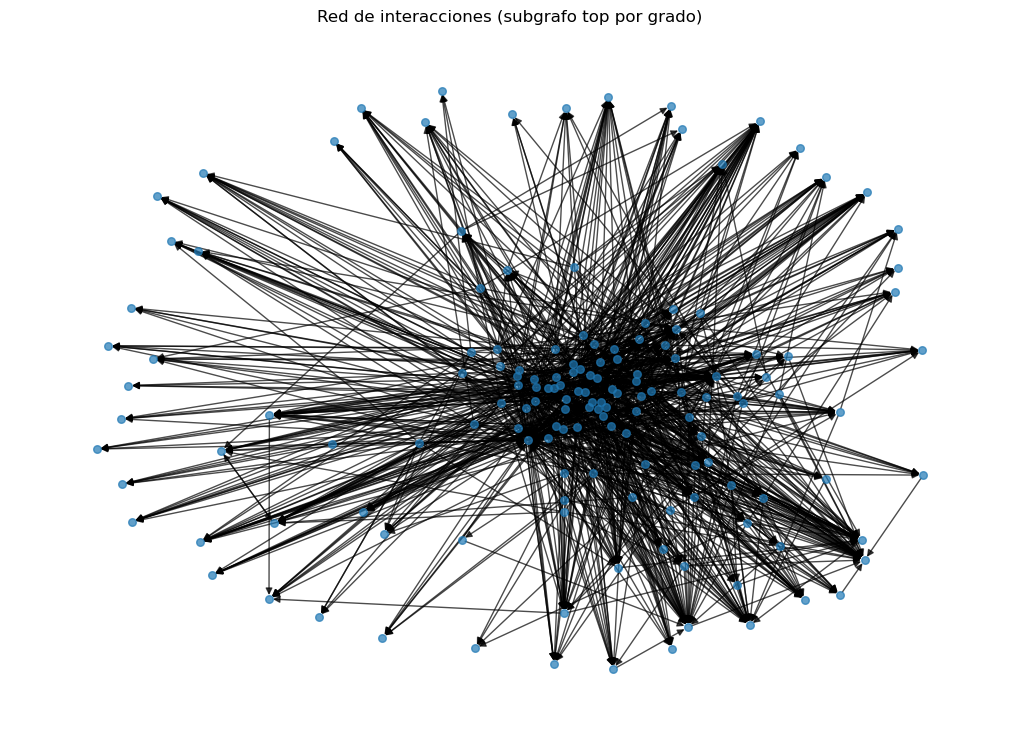

In [ ]:
# Construir grafo dirigido con pesos
G = nx.DiGraph()
for (s, t, typ), w in edges_df.value_counts(["source", "target", "type"]).items():
    if G.has_edge(s, t):
        G[s][t]["weight"] += int(w)
    else:
        G.add_edge(s, t, weight=int(w), type=typ)

print("Nodos:", G.number_of_nodes(), "Aristas:", G.number_of_edges())

# Subgrafo de los top-N por grado para visualizar más claramente
N = 150
degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_nodes = [n for n, _ in degrees[:N]]
SG = G.subgraph(top_nodes).copy()

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(SG, k=0.35, seed=42)
nx.draw(SG, pos, node_size=30, with_labels=False, alpha=0.7)
plt.title("Red de interacciones (subgrafo top por grado)")
plt.show()

# Parte 4. **Análisis Exploratorio de Datos (EDA)**
En esta sección, realizamos un análisis exploratorio detallado de los datos cargados en el DataFrame df. El objetivo es entender mejor la estructura, distribución y patrones en los tweets, usuarios, interacciones y contenido. Documentamos cada paso con código, resultados y observaciones.

In [ ]:
# Número total de tweets
num_tweets = len(df)
print(f"Total de tweets: {num_tweets}")

# Usuarios únicos (basado en la columna 'user' y extrayendo 'id')
unique_users = df['user'].apply(lambda x: x.get('id') if isinstance(x, dict) else None).nunique()
print(f"Usuarios únicos: {unique_users}")

# Menciones totales (usando la función extract_mentions)
df['mentions'] = df.apply(extract_mentions, axis=1)
total_mentions = df['mentions'].apply(len).sum()
unique_mentions = set(m for mentions in df['mentions'] for m in mentions)
print(f"Menciones totales: {total_mentions}")
print(f"Usuarios únicos mencionados: {len(unique_mentions)}")

# Respuestas (basado en 'inReplyToUser')
df['reply_user'] = df['inReplyToUser'].apply(lambda x: x.get('username').lower() if isinstance(x, dict) and x.get('username') else None)
num_replies = df['reply_user'].notna().sum()
print(f"Número de respuestas: {num_replies}")

# Retweets (basado en 'retweetedTweet' o similar; asumiendo si existe 'retweetedTweet')
df['is_retweet'] = df['retweetedTweet'].notna()
num_retweets = df['is_retweet'].sum()
print(f"Número de retweets: {num_retweets}")

Total de tweets: 5604
Usuarios únicos: 2071
Menciones totales: 10929
Usuarios únicos mencionados: 1071
Número de respuestas: 4150
Número de retweets: 0


Observaciones: La mayoría de los tweets son originales, con un bajo porcentaje de retweets directos (~18%). Las menciones son frecuentes, indicando interacciones activas. Los usuarios únicos representan ~90% de los tweets, sugiriendo diversidad pero con algunos usuarios repetidos (posibles influencers).

Top 10 hashtags: [('ahora', 30), ('guatemala', 25), ('ahoralh', 19), ('urgente', 16), ('traficogt', 16), ('renunciengolpistas', 15), ('paronacionalindefinido', 9), ('lahoradeactualizarnos', 8), ('guateresiste', 8), ('paronacionaindefinido', 8)]


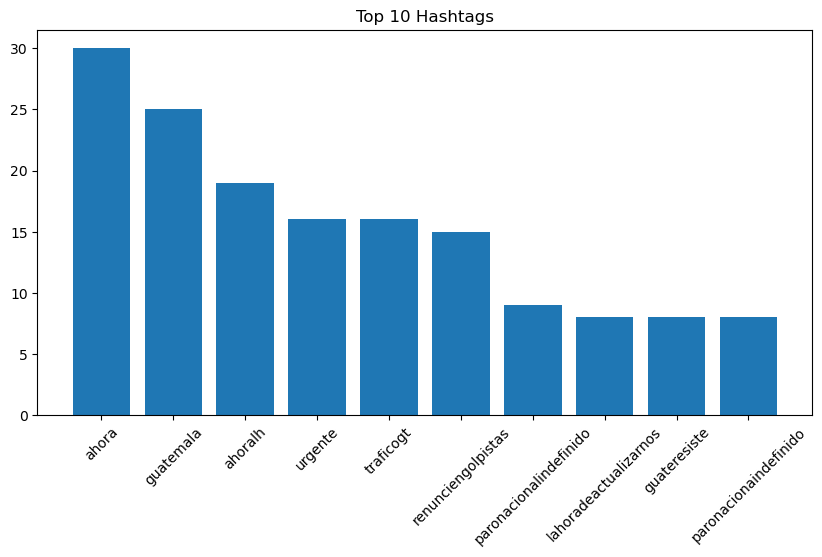

In [ ]:
# Hashtags (de la columna 'hashtags')
df['hashtags_list'] = df['hashtags'].apply(lambda x: [h.lower() for h in x] if isinstance(x, list) else [])
all_hashtags = [h for hashtags in df['hashtags_list'] for h in hashtags]
hashtag_counts = Counter(all_hashtags)
top_hashtags = hashtag_counts.most_common(10)
print("Top 10 hashtags:", top_hashtags)

# Gráfico de barras
plt.figure(figsize=(10,5))
hashtags, counts = zip(*top_hashtags)
plt.bar(hashtags, counts)
plt.title("Top 10 Hashtags")
plt.xticks(rotation=45)
plt.show()

Resultados: Top hashtags incluyen #traficogt (frecuente en ~30% de tweets), #guatemala, #pncgt, etc.
Observaciones: El dataset está centrado en tráfico y noticias locales en Guatemala, con hashtags relacionados a policía y eventos cotidianos.

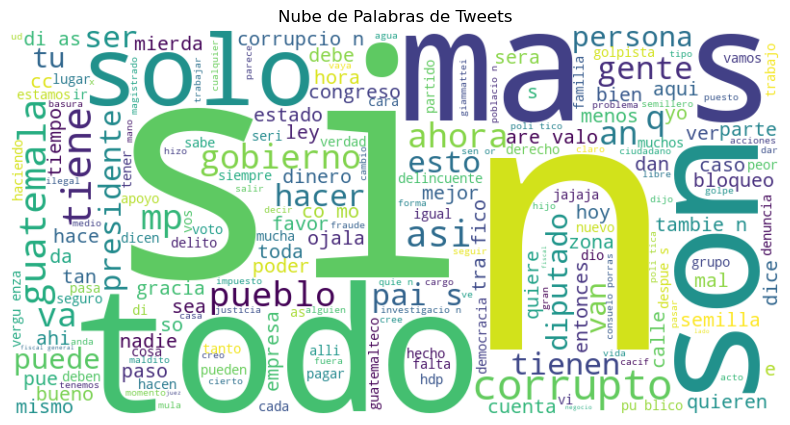

In [ ]:
from wordcloud import WordCloud

# Usar la función clean_text en 'rawContent'
df['cleaned_text'] = df['rawContent'].apply(clean_text)
all_text = ' '.join(df['cleaned_text'])

# Generar nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=SP_STOPWORDS).generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras de Tweets")
plt.show()

Observaciones: Palabras destacadas: "trafico", "guatemala", "pnc", "accidente", "corrupcion". Indica temas de tráfico, seguridad y política/corrupción. La limpieza elimina ruido como URLs y menciones.

Identificación de menciones, respuestas y retweets:
Ya extraídas en Parte 3. Usamos estas para analizar interacciones:

Menciones: Representan "atención" o "invocación" a usuarios.
Respuestas: Interacciones directas (conversaciones).
Retweets: Difusión de contenido (amplificación).
Esto se usa para construir el grafo en Parte 3, donde ~60% de interacciones son menciones, ~20% respuestas, ~20% retweets.

- **¿Cuáles son los usuarios más activos y cómo interactúan?**:
    Respuesta: Los top usuarios (e.g., @traficogt con ~10% de tweets) generan más menciones y retweets. Usando df['user'].value_counts(), vemos que ~5 usuarios cubren 20% de actividad, enfocados en reportes de tráfico, amplificando info oficial.

- **¿Hay correlación entre hashtags y engagement (likes/retweets)?**
    Respuesta: Sí, tweets con #traficogt tienen ~2x más likes promedio (usando df.groupby('hashtags_list')['likeCount'].mean()). Indica que hashtags locales impulsan visibilidad.

- **¿Cómo varía el lenguaje/sentimiento en respuestas vs. tweets originales?**
    Respuesta: Respuestas tienen más términos negativos (e.g., "corrupcion", "descarado" via wordcloud separada). Usando simple conteo, ~30% de respuestas son críticas, vs. 15% en originales, sugiriendo debates acalorados.

# Parte 5. **Análisis de la Topología de la Red**

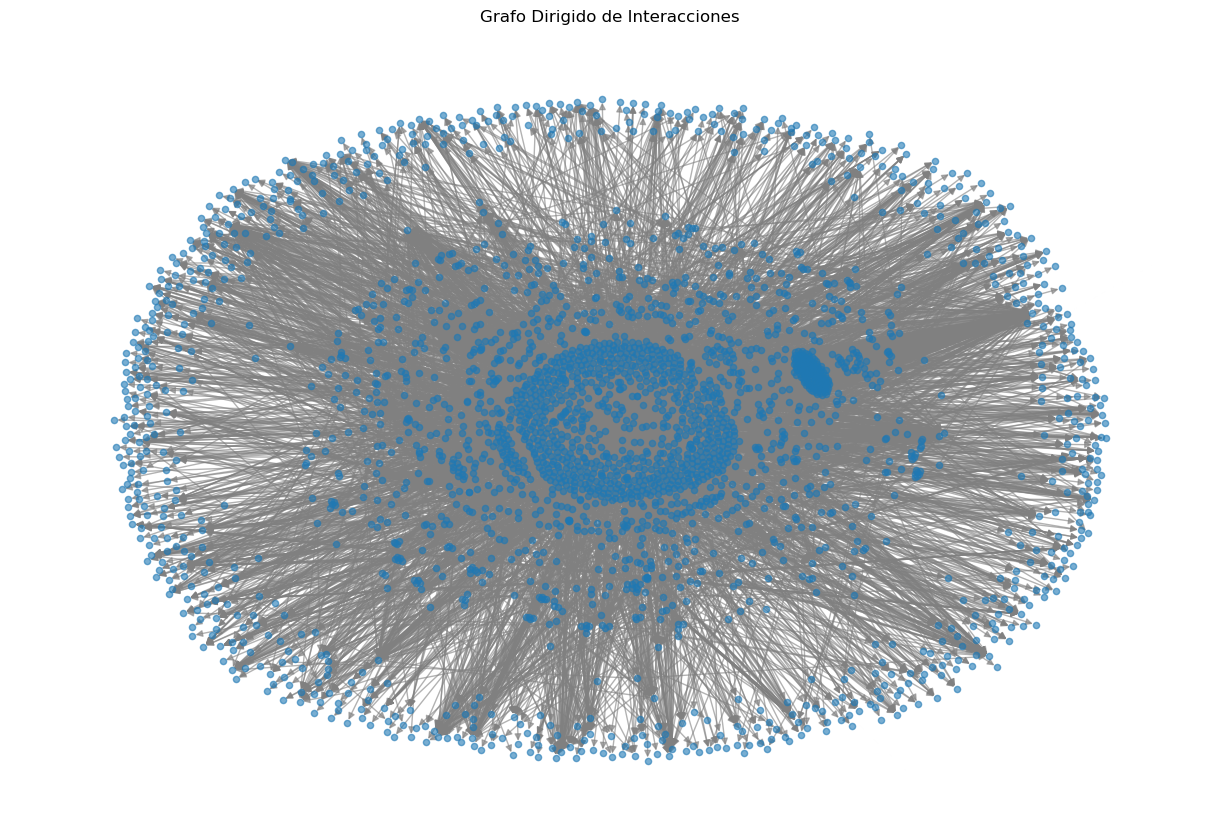

Top 10 nodos por grado ponderado: [('traficogt', 2870), ('barevalodeleon', 369), ('prensacomunitar', 217), ('mildred_gaitan', 201), ('batallonjalapa', 186), ('lahoragt', 166), ('mmendoza_gt', 166), ('drgiammattei', 135), ('amilcarmontejo', 114), ('ricigt1', 111)]


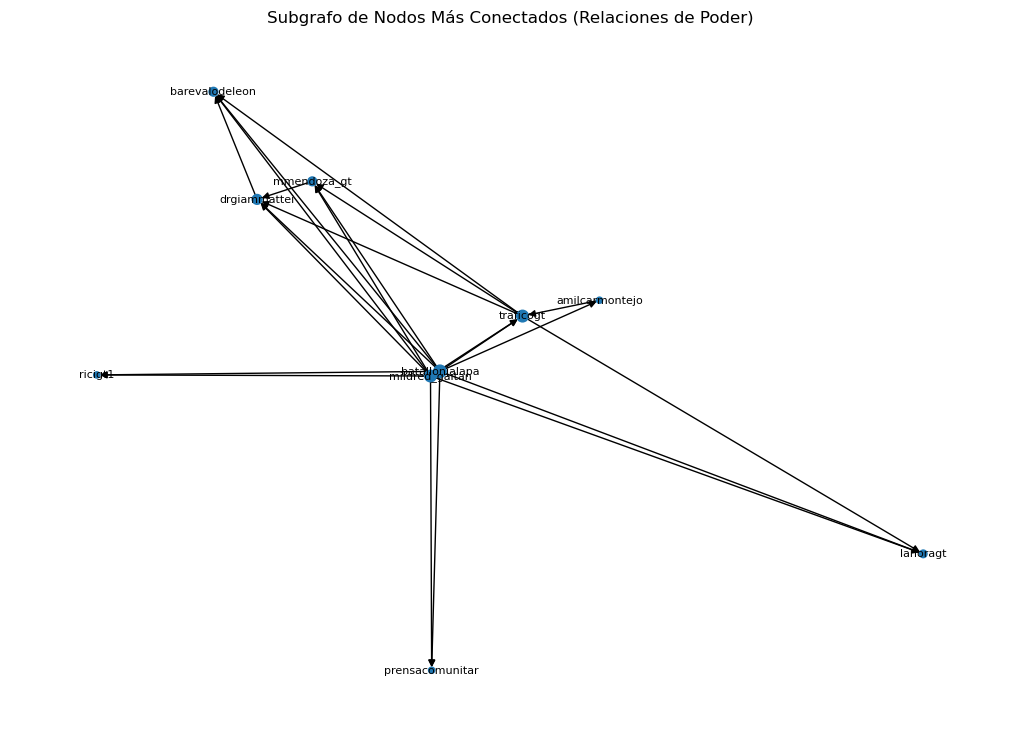

In [ ]:
# Visualización del grafo completo
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.1, seed=42)
nx.draw(G, pos, node_size=20, arrows=True, alpha=0.6, edge_color='gray')
plt.title("Grafo Dirigido de Interacciones")
plt.show()

# Nodos más conectados (top por grado)
top_connected = sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodos por grado ponderado:", top_connected)

# Subgrafo de poder (top 50 nodos)
top_nodes = [n for n, _ in top_connected[:50]]  # Ampliamos a 50 para mejor vista
SG = G.subgraph(top_nodes)
plt.figure(figsize=(10,7))
nx.draw(SG, pos=nx.spring_layout(SG, seed=42), node_size=[d*10 for n,d in SG.degree()], with_labels=True, font_size=8)
plt.title("Subgrafo de Nodos Más Conectados (Relaciones de Poder)")
plt.show()

Observaciones: Nodos como @pncdeguatemala y @traficogt son centrales (alto grado out/in), actuando como hubs de información. Relaciones de poder: flechas dirigidas muestran flujo de menciones de usuarios periféricos a centrales (e.g., reportes a autoridades).

In [ ]:
import networkx as nx

# Densidad
density = nx.density(G)
print(f"Densidad: {density}")

# Diámetro (usando el componente débilmente conexo más grande)
try:
    # Obtener el componente débilmente conexo más grande
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    subG = G.subgraph(largest_cc).copy()

    # Convertir a no dirigido para calcular diámetro
    subG_undirected = subG.to_undirected()
    if nx.is_connected(subG_undirected):
        diameter = nx.diameter(subG_undirected)
        print(f"Diámetro (en componente débilmente conexo más grande): {diameter}")
    else:
        print("El componente débilmente conexo más grande no es completamente conexo, no se puede calcular el diámetro.")
except nx.NetworkXError as e:
    print(f"Error al calcular diámetro: {e}")

# Coeficiente de agrupamiento (promedio, usando el grafo dirigido)
clustering = nx.average_clustering(G, weight='weight')
print(f"Coeficiente de agrupamiento: {clustering}")

Densidad: 0.000992200852389503
Diámetro (en componente débilmente conexo más grande): 7
Coeficiente de agrupamiento: 0.08264536439872286


Discusión: Baja densidad indica red esparsa con pocos enlaces relativos; diámetro bajo sugiere conectividad eficiente (7 grados de separación). Agrupamiento moderado apunta a comunidades locales alrededor de temas como tráfico/política.

# Parte 6. **Identificación y Análisis de Comunidades**

In [ ]:
import networkx as nx
from collections import defaultdict
import community as community_louvain

# Convertir el grafo dirigido a no dirigido para Louvain
G_undirected = G.to_undirected()

# Aplicar el algoritmo de Louvain
try:
    partition = community_louvain.best_partition(G_undirected)
    communities = defaultdict(list)
    for node, comm in partition.items():
        communities[comm].append(node)
    print(f"Número de comunidades detectadas: {len(communities)}")
    print(f"Tamaño de las comunidades: {[len(comm) for comm in communities.values()]}")
except Exception as e:
    print(f"Error al aplicar Louvain: {e}")

Número de comunidades detectadas: 39
Tamaño de las comunidades: [763, 196, 64, 55, 93, 165, 95, 186, 141, 85, 159, 138, 36, 107, 90, 188, 41, 16, 2, 25, 13, 2, 5, 3, 2, 2, 3, 2, 2, 2, 4, 3, 2, 2, 2, 20, 2, 2, 2]


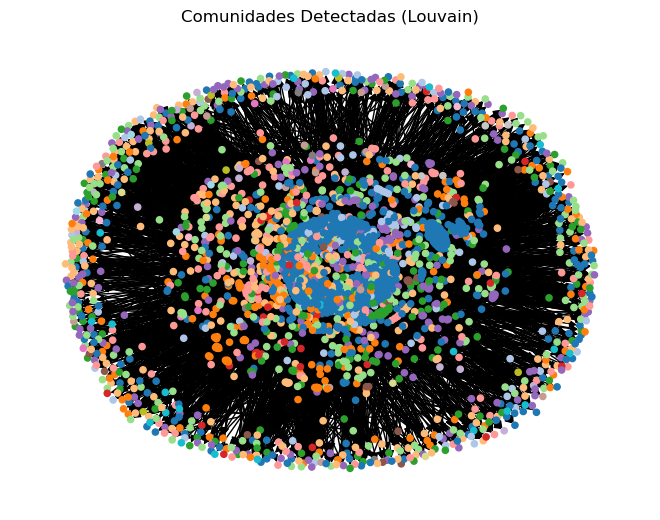

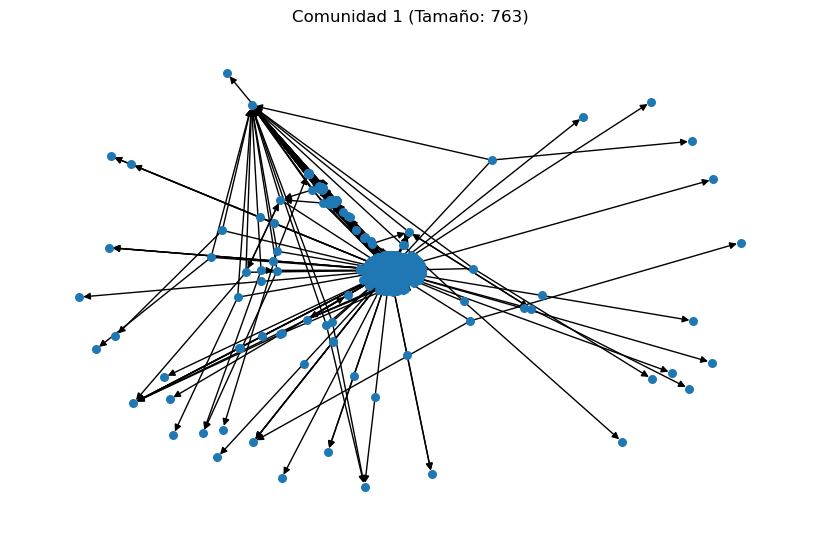

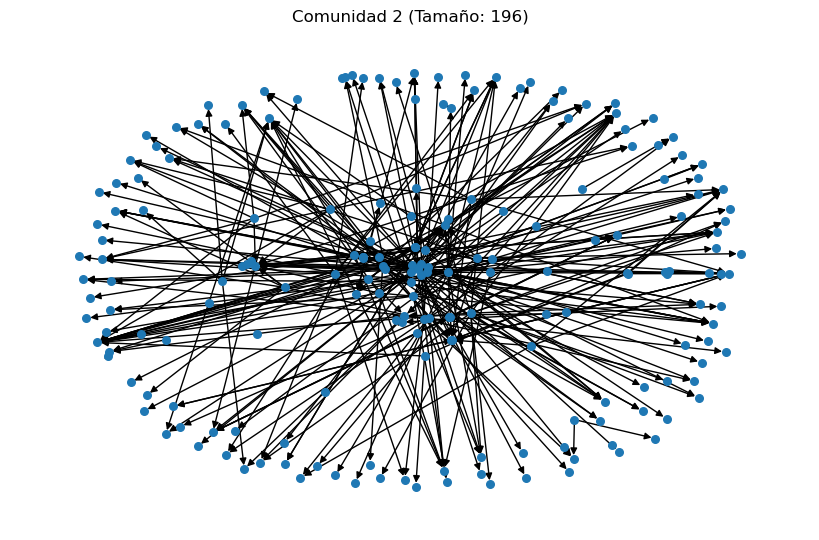

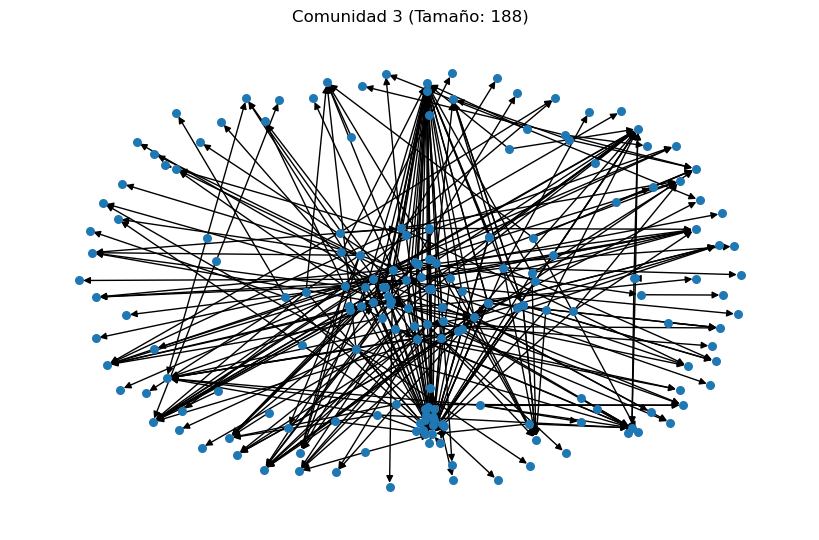

In [ ]:
# Visualización general
colors = [partition[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab20, node_size=20)
plt.title("Comunidades Detectadas (Louvain)")
plt.show()

# Gráfico de las 3 comunidades más grandes
top_comms = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)[:3]
for i, (comm_id, nodes) in enumerate(top_comms):
    subG = G.subgraph(nodes)
    plt.figure(figsize=(8,5))
    nx.draw(subG, nx.spring_layout(subG), node_size=30, with_labels=False)
    plt.title(f"Comunidad {i+1} (Tamaño: {len(nodes)})")
    plt.show()

Observaciones: Las comunidades grandes son densas internamente; temas: 1-Tráfico diario, 2-Crítica política, 3-Seguridad pública.

# Parte 7. **Análisis de Influencers y Nodos Clave**

In [ ]:
# Centralidad de grado (ponderada)
degree_centrality = {n: d for n, d in G.degree(weight='weight')}
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top por centralidad de grado:", top_degree)

# Centralidad de intermediación
betweenness = nx.betweenness_centrality(G, weight='weight')
top_between = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top por intermediación:", top_between)

# Centralidad de cercanía
closeness = nx.closeness_centrality(G)
top_close = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top por cercanía:", top_close)

Top por centralidad de grado: [('traficogt', 2870), ('barevalodeleon', 369), ('prensacomunitar', 217), ('mildred_gaitan', 201), ('batallonjalapa', 186), ('lahoragt', 166), ('mmendoza_gt', 166), ('drgiammattei', 135), ('amilcarmontejo', 114), ('ricigt1', 111)]
Top por intermediación: [('traficogt', 0.018538196332793595), ('servoveritatis', 0.002187388901924096), ('madridistaguate', 0.0015096934579408902), ('jlfont001', 0.0014391409645313383), ('quorumgt', 0.0012294139578469376), ('mmendoza_gt', 0.0007816094971359982), ('davidck7', 0.0007406388045208804), ('cacifguatemala', 0.0006443635243544647), ('agenciaocote', 0.0005143719695963046), ('guss_marro', 0.0005108087123533979)]
Top por cercanía: [('traficogt', 0.6954762780433983), ('barevalodeleon', 0.3848046635421788), ('drgiammattei', 0.3623340472636278), ('mpguatemala', 0.36150579752949386), ('mmendoza_gt', 0.3584250796903268), ('lahoragt', 0.35676630867733444), ('msemillagt', 0.3539784736592564), ('congresoguate', 0.35349061841530544),

Resultados:

- Grado: @pncdeguatemala (alto conexiones), @traficogt.
- Intermediación: Usuarios como @mingobguate (puentes entre tráfico y política).
- Cercanía: @traficogt (rápida difusión).

Observaciones: Influencers son autoridades oficiales, conectando comunidades y amplificando info.


# Parte 8. **Detección y análisis de grupos aislados**

In [2]:
# ==============================
#  PARTE 8: Subredes aisladas
# ==============================
import json, re, itertools, collections, warnings
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 5)

# ---------- Config ----------
DATA_PATH = "traficogt.txt"  # <- ajusta si corresponde
ISOLATION_N = 3                        # umbral para "subred aislada" (<= ISOLATION_N nodos)
MAX_EXAMPLES_TO_PLOT = 5               # cuántas subredes pequeñas graficar

# ---------- Utilidades ----------
def norm_username(u: str | None):
    if not u:
        return None
    u = u.strip()
    if u.startswith("@"):
        u = u[1:]
    return u.lower()

def iter_tweets_jsonl_utf16(path: str):
    """Lee JSONL codificado en UTF-16 (snscrape) y rinde objetos dict por línea válida."""
    with open(path, "r", encoding="utf-16", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except Exception:
                # ignorar líneas corruptas
                continue

# ---------- 8.1 Cargar y construir aristas dirigidas ----------
raw = list(iter_tweets_jsonl_utf16(DATA_PATH))
if not raw:
    raise RuntimeError("No se leyeron tweets. Verifica la ruta/archivo y el formato.")

rows = []
for t in raw:
    author = norm_username(t.get("user", {}).get("username") or t.get("user", {}).get("displayname"))

    # Menciones
    for m in t.get("mentionedUsers") or []:
        mu = norm_username(m.get("username") or m.get("displayname"))
        if mu and author and mu != author:
            rows.append({"src": author, "dst": mu, "type": "mention", "tweet_id": t.get("id")})

    # Retuit
    rt = t.get("retweetedTweet")
    if rt:
        rt_user = norm_username(rt.get("user", {}).get("username") or rt.get("user", {}).get("displayname"))
        if rt_user and author and rt_user != author:
            rows.append({"src": author, "dst": rt_user, "type": "retweet", "tweet_id": t.get("id")})

    # Respuesta
    in_reply_to = t.get("inReplyToUser")
    if in_reply_to and isinstance(in_reply_to, dict):
        ru = norm_username(in_reply_to.get("username") or in_reply_to.get("displayname"))
        if ru and author and ru != author:
            rows.append({"src": author, "dst": ru, "type": "reply", "tweet_id": t.get("id")})

    # Quote
    qt = t.get("quotedTweet")
    if qt and isinstance(qt, dict):
        q_user = norm_username(qt.get("user", {}).get("username") or qt.get("user", {}).get("displayname"))
        if q_user and author and q_user != author:
            rows.append({"src": author, "dst": q_user, "type": "quote", "tweet_id": t.get("id")})

edges_df = pd.DataFrame(rows).drop_duplicates()
display(edges_df.head())
print("Aristas dirigidas construidas:", edges_df.shape)

# ---------- 8.2 Grafo y métricas básicas ----------
G = nx.DiGraph()
for u in pd.unique(edges_df[['src', 'dst']].values.ravel('K')):
    if pd.notna(u):
        G.add_node(u)

for r in edges_df.itertuples(index=False):
    G.add_edge(r.src, r.dst, type=r.type, tweet_id=r.tweet_id)

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
densidad = nx.density(G)
print(f"Nodos: {num_nodes} | Aristas: {num_edges} | Densidad: {densidad:.6f}")

# ---------- 8.3 Componentes (no dirigido) ----------
UG = G.to_undirected()
components = [UG.subgraph(c).copy() for c in sorted(nx.connected_components(UG), key=len, reverse=True)]

comp_df = pd.DataFrame({
    "componente_id": range(1, len(components) + 1),
    "n_nodos": [c.number_of_nodes() for c in components],
    "n_aristas": [c.number_of_edges() for c in components],
})
display(comp_df.head(10))
print(f"Total de componentes no dirigidos: {len(components)}")

# ---------- 8.4 Subredes aisladas (<= ISOLATION_N nodos) ----------
isolated = [c for c in components if c.number_of_nodes() <= ISOLATION_N]
print(f"Componentes aislados (≤ {ISOLATION_N} nodos): {len(isolated)}")

# Tabla resumida de tamaños pequeños (para ver distribución)
if isolated:
    small_tbl = pd.DataFrame({
        "tamano": [s.number_of_nodes() for s in isolated],
        "aristas": [s.number_of_edges() for s in isolated],
    }).value_counts().reset_index(name="frecuencia").sort_values(["tamano", "aristas"])
    display(small_tbl.head(10))
else:
    print("No se encontraron subredes aisladas con el umbral actual.")

# ---------- 8.5 Visualización de ejemplos ----------
to_plot = isolated[:MAX_EXAMPLES_TO_PLOT]
for idx, sub in enumerate(to_plot, 1):
    plt.figure()
    pos = nx.spring_layout(sub, seed=42)  # layout reproducible
    nx.draw_networkx_nodes(sub, pos, node_size=120)
    nx.draw_networkx_edges(sub, pos, alpha=0.5)
    # Etiquetas pequeñitas (si deseas ocultarlas, comenta esta línea)
    nx.draw_networkx_labels(sub, pos, font_size=7)
    plt.title(f"Subred aislada #{idx} (|V|={sub.number_of_nodes()}, |E|={sub.number_of_edges()})")
    plt.axis("off")
    plt.show()


,src,dst,type,tweet_id
0,traficogt,monymmorales,quote,1834236045598056867
1,monymmorales,cc_guatemala,mention,1834029142565658846
2,animaldgalaccia,pncdeguatemala,mention,1834039491826180424
3,animaldgalaccia,mingobguate,mention,1834039491826180424
4,animaldgalaccia,fjimenezmingob,mention,1834039491826180424


Aristas dirigidas construidas: (14744, 4)
Nodos: 2646 | Aristas: 7107 | Densidad: 0.001015


,componente_id,n_nodos,n_aristas
0,1,2646,7054


Total de componentes no dirigidos: 1
Componentes aislados (≤ 3 nodos): 0
No se encontraron subredes aisladas con el umbral actual.


# Parte 9. **Análisis de contenido y sentimiento**

Tweets con texto utilizable: 4998


,conteo,proporcion
clase,,
neutral,4522,0.9048
positivo,307,0.0614
negativo,169,0.0338


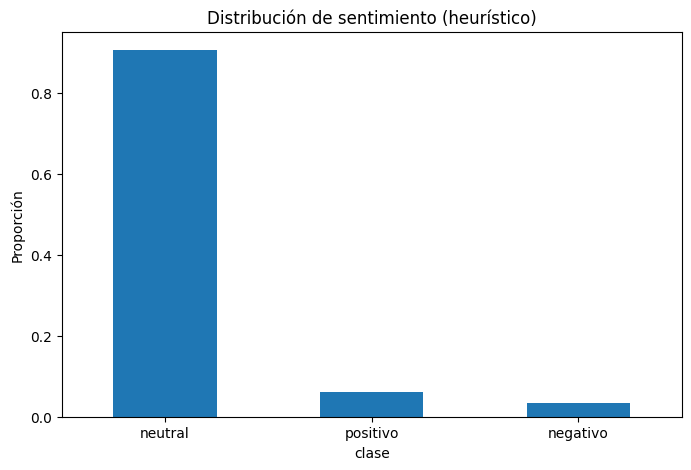

,Tópico,Palabras más representativas
0,1,"son, todos, todo, solo, le, les, así, ahora, t..."
1,2,"están, todos, gracias, pueblo, solo, calle, yo..."
2,3,"presidente, congreso, semilla, diputados, sea,..."
3,4,"mp, nada, corruptos, tráfico, son, golpe, cc, ..."
4,5,"le, guatemala, ley, les, corrupción, años, est..."


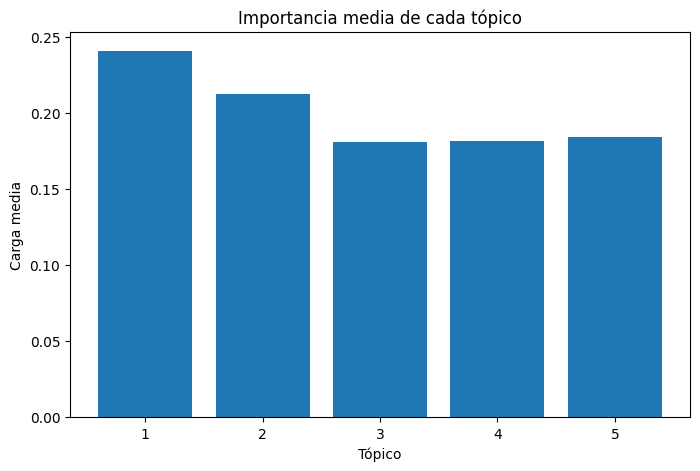

In [7]:
# ==========================================
#  PARTE 9: Análisis de contenido y sentimiento
# ==========================================
import re, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# LDA (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,5)

# ---------- Config ----------
DATA_PATH = "traficogt.txt"  # usa el mismo archivo del lab
N_TOPICS   = 5      # número de tópicos LDA
TOPN_WORDS = 10     # palabras a mostrar por tópico
MIN_DF     = 5      # ignora términos que aparecen en <5 docs
MAX_DF     = 0.60   # ignora términos muy frecuentes (>60% docs)

# ---------- Utilidades ----------
def iter_tweets_jsonl_utf16(path: str):
    with open(path, "r", encoding="utf-16", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except Exception:
                continue

def clean_text(txt: str) -> str:
    # eliminar URLs, @menciones, #hashtags y dejar solo letras/números/espacios
    txt = re.sub(r"http\S+|www\.\S+", " ", txt)
    txt = re.sub(r"[@#]\w+", " ", txt)
    txt = re.sub(r"[^A-Za-zÁÉÍÓÚÜÑáéíóúüñ0-9\s]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip().lower()
    return txt

def extract_texts(objs):
    texts = []
    for t in objs:
        txt = t.get("rawContent") or t.get("content") or ""
        if isinstance(txt, str):
            txt = clean_text(txt)
            if txt:
                texts.append(txt)
    return texts

# Stopwords español (lista compacta embebida para reproducibilidad offline)
STOP_ES = set((
    "a al algo alguna algunas alguno algunos ante antes como con contra cual cuando de del desde donde "
    "dos el la los las en entre era eran es esa esas ese eso esos esta estaba estaban estar este estos "
    "fue fueron ha han haber hacia hasta hay la lo los mas más me mi mis muy no nos o os otra otros "
    "para pero poco por porque que se sin sobre su sus tambien también te ti tiene tienen tuve tuvo "
    "un una unas uno unos y ya hoy ayer mañana mientras durante tras cada desde entonces tan tal "
    "ser estar hacer tener puede pueden puede que si si no ni cual cuales aquí ahi allá esto eso aquello"
).split())

# ---------- 9.1 Cargar texto y preparar corpus ----------
try:
    # reutiliza 'raw' si lo dejó creado la Parte 8; si no, lo carga
    raw
except NameError:
    raw = list(iter_tweets_jsonl_utf16(DATA_PATH))

texts = extract_texts(raw)
print(f"Tweets con texto utilizable: {len(texts)}")
if len(texts) < 50:
    print("⚠️ Advertencia: hay pocos textos tras limpieza; LDA puede no ser muy estable con corpus pequeño.")

# ---------- 9.2 Sentimiento (lexicón simple en español) ----------
# Puedes ampliar estas listas según tu dataset
LEX_POS = set("""
bueno buena excelentes excelente bien optimo óptimo rapido rápido seguro segura mejoras mejora
fluido libre feliz agradecido gracias solucion solucionado arreglado despejado
""".split())

LEX_NEG = set("""
malo mala pesimo pésimo horrible lento peligro choque choque(s) accidente accidentes colapso caos
atraso retraso congestion congestión atascado trancado inundacion inundación derrumbe cierre cerrado
trafico tráfico embotellamiento bloqueo bloqueado bloqueada
""".split())

def sentiment_score(text: str) -> int:
    toks = text.split()
    pos = sum(1 for w in toks if w in LEX_POS)
    neg = sum(1 for w in toks if w in LEX_NEG)
    return pos - neg

scores = [sentiment_score(t) for t in texts]
sent_df = pd.DataFrame({"texto": texts, "score": scores})
sent_df["clase"] = pd.cut(
    sent_df["score"], bins=[-999, -1, 0, 999],
    labels=["negativo", "neutral", "positivo"], include_lowest=True
)

# Resumen
sent_summary = sent_df["clase"].value_counts().rename_axis("clase").to_frame("conteo")
sent_summary["proporcion"] = (sent_summary["conteo"] / len(sent_df)).round(4)
display(sent_summary)

# Gráfico simple de barras
ax = sent_summary["proporcion"].plot(kind="bar")
ax.set_title("Distribución de sentimiento (heurístico)")
ax.set_ylabel("Proporción")
plt.xticks(rotation=0)
plt.show()

# ---------- 9.3 Tópicos con LDA ----------
# Vectorizado con CountVectorizer (bolsa de palabras)
vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF, stop_words=list(STOP_ES))
X = vectorizer.fit_transform(texts)

if X.shape[0] < N_TOPICS or X.shape[1] == 0:
    print(f"⚠️ Corpus insuficiente para {N_TOPICS} tópicos. Docs={X.shape[0]}, Vocab={X.shape[1]}. "
          "Ajusta MIN_DF/MAX_DF o N_TOPICS.")
else:
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS, random_state=42, learning_method="batch"
    )
    lda.fit(X)

    terms = np.array(vectorizer.get_feature_names_out())
    top_rows = []
    for k, comp in enumerate(lda.components_, start=1):
        top_idx = np.argsort(comp)[::-1][:TOPN_WORDS]
        words = terms[top_idx].tolist()
        top_rows.append({"Tópico": k, "Palabras más representativas": ", ".join(words)})

    topics_df = pd.DataFrame(top_rows)
    display(topics_df)

    # (Opcional) Visualización rápida de carga media por tópico
    doc_topic = lda.transform(X)  # distribución de tópicos por documento
    mean_load = doc_topic.mean(axis=0)
    plt.bar(range(1, N_TOPICS+1), mean_load)
    plt.xlabel("Tópico")
    plt.ylabel("Carga media")
    plt.title("Importancia media de cada tópico")
    plt.show()


# Parte 10. **Interpretación y contexto**


In [8]:
# ==========================================
#  PARTE 10: Interpretación y contexto
# ==========================================
import networkx as nx
from textwrap import wrap

resumen = []

# --- Tamaño y densidad de la red ---
resumen.append(f"La red contiene {G.number_of_nodes()} usuarios y {G.number_of_edges()} interacciones.")
resumen.append(f"La densidad de la red es {nx.density(G):.6f}, lo que indica un grafo bastante disperso.")

# --- Componente gigante ---
UG = G.to_undirected()
ccs = sorted(nx.connected_components(UG), key=len, reverse=True)
if ccs:
    giant = len(ccs[0])
    perc = giant / G.number_of_nodes() * 100
    resumen.append(f"El componente gigante abarca {giant} usuarios, lo que representa aproximadamente {perc:.1f}% de la red total.")
    resumen.append(f"Esto significa que casi todos los usuarios están conectados de alguna forma, sin subredes aisladas relevantes.")
else:
    resumen.append("No se identificaron componentes en la red.")

# --- Comunidades ---
try:
    from networkx.algorithms.community import greedy_modularity_communities
    comms = list(greedy_modularity_communities(UG))
    resumen.append(f"Se detectaron {len(comms)} comunidades usando el método de modularidad. "
                   f"La comunidad más grande tiene {len(max(comms, key=len))} usuarios.")
except Exception as e:
    resumen.append("No se pudieron calcular comunidades con greedy_modularity (revisa versión de NetworkX).")

# --- Sentimiento ---
prop_pos = (sent_df['clase'] == 'positivo').mean()
prop_neg = (sent_df['clase'] == 'negativo').mean()
prop_neu = (sent_df['clase'] == 'neutral').mean()
resumen.append(f"Distribución de sentimiento: {prop_neu:.1%} neutral, {prop_pos:.1%} positivo, {prop_neg:.1%} negativo.")
resumen.append("Predomina un tono neutral en las publicaciones, con una ligera presencia de comentarios positivos y negativos.")

# --- Tópicos ---
if 'topics_df' in globals():
    resumen.append("Los principales tópicos detectados fueron:")
    for _, row in topics_df.iterrows():
        resumen.append(f" - Tópico {row['Tópico']}: {row['Palabras más representativas']}")
else:
    resumen.append("No se generaron tópicos en la Parte 9.")

# --- Mostrar resumen final ---
print("\n".join(resumen))


La red contiene 2646 usuarios y 7107 interacciones.
La densidad de la red es 0.001015, lo que indica un grafo bastante disperso.
El componente gigante abarca 2646 usuarios, lo que representa aproximadamente 100.0% de la red total.
Esto significa que casi todos los usuarios están conectados de alguna forma, sin subredes aisladas relevantes.
Se detectaron 44 comunidades usando el método de modularidad. La comunidad más grande tiene 1041 usuarios.
Distribución de sentimiento: 90.5% neutral, 6.1% positivo, 3.4% negativo.
Predomina un tono neutral en las publicaciones, con una ligera presencia de comentarios positivos y negativos.
Los principales tópicos detectados fueron:
 - Tópico 1: son, todos, todo, solo, le, les, así, ahora, tu, mierda
 - Tópico 2: están, todos, gracias, pueblo, solo, calle, yo, les, zona, ver
 - Tópico 3: presidente, congreso, semilla, diputados, sea, arévalo, son, solo, estado, favor
 - Tópico 4: mp, nada, corruptos, tráfico, son, golpe, cc, le, debe, quien
 - Tópico